In [1]:
import gpflow
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import sys
sys.path.append('../')
from GPHetero import hetero_kernels, hetero_likelihoods, hetero_gpmc

RuntimeError: module compiled against API version 0xb but this version of numpy is 0xa

RuntimeError: module compiled against API version 0xb but this version of numpy is 0xa

Text(0,0.5,u'$y$')

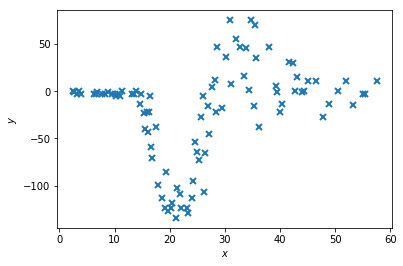

In [2]:
data = np.loadtxt('../data/motor.dat')
X = data[:, 0][:, None]
Xm = np.mean(X)
Xv = np.std(X)
Xnorm = (X - Xm)/Xv
Y = data[:, 1]
fig, ax = plt.subplots()
ax.plot(X, Y, 'x', markeredgewidth=2)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')

In [3]:
#build the model
k1 = hetero_kernels.RBF(1)
nonstat = hetero_kernels.NonStationaryLengthscaleRBF()
m = hetero_gpmc.GPMCAdaptiveLengthscale(Xnorm, Y[:,None], k1, nonstat)

In [4]:
m

Name,values,prior,constraint
adaptive_lengthscale_gp.V1,[[ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.]],"N([ 0.],[ 1.])",(none)
adaptive_lengthscale_gp.V2,[[ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.]],"N([ 0.],[ 1.])",(none)
adaptive_lengthscale_gp.kern1.lengthscales,[ 1.],None,+ve
adaptive_lengthscale_gp.kern1.variance,[ 1.],None,+ve
adaptive_lengthscale_gp.likelihood.variance,[ 1.],None,+ve
adaptive_lengthscale_gp.nonstat.signal_variance,[ 1.],None,+ve


In [5]:
#m.kern1.lengthscales.prior = gpflow.priors.Gamma(1., 1.)
#m.kern1.variance.prior = gpflow.priors.Gamma(1.,1.)

m.kern1.lengthscales = 1.
m.kern1.lengthscales.fixed = True
m.kern1.variance = 1.
m.kern1.variance.fixed = True

m.likelihood.variance.prior = gpflow.priors.Gamma(1.,1.)
m.nonstat.signal_variance.prior = gpflow.priors.Gamma(1.,1.)

In [6]:
m.optimize(maxiter=1000) # start near MAP

      fun: array([ 944.35793008])
 hess_inv: <190x190 LbfgsInvHessProduct with dtype=float64>
      jac: array([ -1.37129749e-02,  -1.13555949e-02,  -2.95886103e-03,
        -3.61794090e-03,  -3.03698516e-03,  -2.60747296e-03,
        -7.59004042e-04,  -6.61278380e-04,  -1.14167571e-03,
        -4.28916602e-04,  -5.09736587e-04,  -6.60190424e-04,
        -4.68795510e-04,  -4.35025006e-04,  -5.08394306e-04,
        -5.41311886e-04,  -5.87331699e-04,  -1.10046482e-03,
         2.23396458e-04,  -3.47855247e-04,  -8.88466076e-04,
        -6.58163819e-05,   6.78429655e-04,  -3.59249911e-04,
        -5.20567489e-04,  -6.97315133e-04,   1.18865562e-04,
         1.06341854e-03,   9.36028617e-04,  -6.35553741e-04,
         5.02575354e-04,   4.75459990e-04,   8.09707928e-04,
         6.47905488e-04,   5.15088338e-04,   5.72647996e-04,
         1.10142352e-03,   7.98711334e-04,   1.34629401e-03,
         1.31167938e-03,  -2.76953541e-04,   2.70802178e-04,
         3.09638404e-03,   4.36885945e-03

In [7]:
samples = m.sample(2000, verbose=True, epsilon=0.025, thin = 2, burn = 1000, Lmax = 80)

burn-in sampling started
Iteration:  100 	 Acc Rate:  18.0 %
Iteration:  200 	 Acc Rate:  9.0 %
Iteration:  300 	 Acc Rate:  11.0 %
Iteration:  400 	 Acc Rate:  13.0 %
Iteration:  500 	 Acc Rate:  21.0 %
Iteration:  600 	 Acc Rate:  41.0 %
Iteration:  700 	 Acc Rate:  65.0 %
Iteration:  800 	 Acc Rate:  55.0 %
Iteration:  900 	 Acc Rate:  51.0 %
Iteration:  1000 	 Acc Rate:  50.0 %
burn-in sampling ended
Iteration:  100 	 Acc Rate:  48.0 %
Iteration:  200 	 Acc Rate:  44.0 %
Iteration:  300 	 Acc Rate:  54.0 %
Iteration:  400 	 Acc Rate:  53.0 %
Iteration:  500 	 Acc Rate:  53.0 %
Iteration:  600 	 Acc Rate:  22.0 %
Iteration:  700 	 Acc Rate:  47.0 %
Iteration:  800 	 Acc Rate:  59.0 %
Iteration:  900 	 Acc Rate:  55.0 %
Iteration:  1000 	 Acc Rate:  57.0 %
Iteration:  1100 	 Acc Rate:  65.0 %
Iteration:  1200 	 Acc Rate:  70.0 %
Iteration:  1300 	 Acc Rate:  47.0 %
Iteration:  1400 	 Acc Rate:  40.0 %
Iteration:  1500 	 Acc Rate:  64.0 %
Iteration:  1600 	 Acc Rate:  42.0 %
Iteration

In [8]:
m

Name,values,prior,constraint
adaptive_lengthscale_gp.V1,[[ -1.81720454e+00] [ -7.11744497e-01] [ 2.42383880e-02] [ 1.82406689e-01] [ 1.83175596e-01] [ 2.10389828e-01] [ 8.77869188e-02] [ 7.30387885e-02] [ 9.31656628e-02] [ -7.48230800e-03] [ -8.85188456e-02] [ -2.15121099e-01] [ -2.06382347e-01] [ -1.79956373e-01] [ -2.93631044e-01] [ -3.57111041e-01] [ -3.85259522e-01] [ -8.59755343e-01] [ -3.87495251e-01] [ -3.33469715e-01] [ -8.11311363e-01] [ -4.78017726e-01] [ -6.88835019e-01] [ -4.57314288e-01] [ -4.15525439e-01] [ -4.06140971e-01] [ -4.23765801e-01] [ -4.40166400e-01] [ -4.37197193e-01] [ -4.49476520e-01] [ -8.89001366e-01] [ -5.25436613e-01] [ -8.23058616e-01] [ -7.32543838e-01] [ -4.63809032e-01] [ -4.05993396e-01] [ -6.69352766e-01] [ -4.80808956e-01] [ -7.51952516e-01] [ -4.33542087e-01] [ -4.60307713e-01] [ -3.66750768e-01] [ -7.73232493e-01] [ -3.52305459e-01] [ -4.64101444e-01] [ -3.28169743e-01] [ -3.79502229e-01] [ -3.86897826e-01] [ -3.59476799e-01] [ -2.95075121e-01] [ -3.21240044e-01] [ -2.32735135e-01] [ -2.12904219e-01] [ -3.20335942e-01] [ -2.23425781e-01] [ -2.29820319e-01] [ -2.72097746e-01] [ -1.72223668e-01] [ -1.45029558e-01] [ -2.47901345e-01] [ -2.42428635e-01] [ -2.06425204e-01] [ -1.11106590e-01] [ -1.61127084e-01] [ -1.55031554e-01] [ -1.19094073e-01] [ -8.44409665e-02] [ -9.42206638e-02] [ -7.42267101e-02] [ -6.71264387e-02] [ -5.06010431e-02] [ -4.46801450e-02] [ -7.16313310e-02] [ -1.02015580e-01] [ -6.31692161e-02] [ -2.77466305e-02] [ -4.21450014e-02] [ -3.76393563e-02] [ -5.51148639e-02] [ -3.43854131e-02] [ -2.26891118e-02] [ -1.55986204e-02] [ -3.03644342e-02] [ -1.91627919e-02] [ -1.89870595e-02] [ -2.48786792e-02] [ -1.41775795e-02] [ -9.91890575e-03] [ -9.51343254e-03] [ -4.58185153e-03] [ -2.40216649e-03] [ -1.40889728e-03] [ -3.89311503e-04] [ -4.87170595e-04]],"N([ 0.],[ 1.])",(none)
adaptive_lengthscale_gp.V2,[[-0.08799328] [-0.09390726] [-0.07902708] [-0.06998068] [-0.06521753] [-0.11301565] [-0.14756418] [-0.17373903] [-0.16216628] [-0.04033007] [ 0.09780162] [ 0.24052263] [ 0.25126119] [ 0.08139038] [-0.0505409 ] [-0.3227732 ] [-0.68217465] [-2.21032874] [-3.66669089] [-4.34601621] [-4.2851573 ] [-4.46606503] [-3.99166915] [-3.83489985] [-2.13015938] [-2.2135454 ] [-2.44954849] [-2.18491814] [-1.80392742] [-1.59479212] [-2.34608093] [-1.37476971] [-1.06099482] [-0.42875794] [ 0.11919983] [ 0.22617323] [ 0.5316128 ] [ 0.52527037] [ 1.04429514] [ 0.73965756] [ 1.20408898] [ 0.66872499] [ 1.42497519] [ 0.55376662] [ 0.92538812] [ 0.14622645] [-0.37471941] [-1.07984915] [-1.40719383] [-0.8867169 ] [-0.7161559 ] [ 0.11062909] [ 0.53211184] [ 0.9080959 ] [ 0.25124844] [ 0.05244196] [-0.43048573] [-0.01169394] [ 0.25281088] [ 0.88713651] [ 0.54621184] [ 0.43854329] [ 0.73286905] [ 0.68138961] [ 1.1919835 ] [ 1.39495368] [ 1.05918265] [ 0.24053562] [-0.65585725] [-0.81852279] [-0.27858056] [ 0.2945923 ] [ 0.79276731] [ 2.02488367] [-0.41980704] [-0.83588379] [-0.64544127] [ 0.27189972] [ 1.68394966] [ 0.88018773] [ 0.0320526 ] [ 0.06404783] [-0.051702 ] [ 0.30220852] [ 0.38365212] [ 0.3535589 ] [-1.35501462] [-0.39087476] [ 0.13636345] [ 0.16902977] [-0.71060228] [ 0.07999865] [ 0.29293625] [ 0.3763399 ]],"N([ 0.],[ 1.])",(none)
adaptive_lengthscale_gp.kern1.lengthscales,[ 1.],None,[FIXED]
adaptive_lengthscale_gp.kern1.variance,[ 1.],None,[FIXED]
adaptive_lengthscale_gp.likelihood.variance,[ 115.08213079],"Ga([ 1.],[ 1.])",+ve
adaptive_lengthscale_gp.nonstat.signal_variance,[ 88.66230619],"Ga([ 1.],[ 1.])",+ve


In [9]:
xnew = np.linspace(0,60,50)[:,None]
xx = (xnew - Xm)/Xv

In [10]:
sample_df = m.get_samples_df(samples)

In [11]:
mean_l_mat = np.zeros(shape = (samples.shape[0], xx.shape[0]))
var_l_mat = np.zeros(shape = (samples.shape[0], xx.shape[0]))

In [12]:
for i, s in sample_df.iterrows():
    m.set_parameter_dict(s)
    mean1, v1 = m.predict_l(xx)
    var1 = v1[:,:]
    mean_l_mat[i,:] = mean1[:,0]
    var_l_mat[i,:] = np.diag(var1)

std_l_mat = np.sqrt(var_l_mat)

In [13]:
LowerlogL = mean_l_mat - 2*std_l_mat
UpperlogL = mean_l_mat + 2*std_l_mat

In [14]:
MeanL = np.exp(mean_l_mat)
LowerL = np.exp(LowerlogL)
UpperL = np.exp(UpperlogL)

In [15]:
LowerL

array([[ 0.52764045,  0.45469458,  0.39309105, ...,  0.15755456,
         0.19654086,  0.24411279],
       [ 0.52764045,  0.45469458,  0.39309105, ...,  0.15755456,
         0.19654086,  0.24411279],
       [ 0.10920333,  0.11176749,  0.11512012, ...,  0.03056385,
         0.03424146,  0.03891042],
       ..., 
       [ 0.11222924,  0.10089361,  0.09370375, ...,  0.39186332,
         0.51546512,  0.67898042],
       [ 0.11222924,  0.10089361,  0.09370375, ...,  0.39186332,
         0.51546512,  0.67898042],
       [ 0.07403765,  0.06937221,  0.06741647, ...,  0.58176011,
         0.76162719,  0.97839281]])

In [17]:
mean_f_mat = np.zeros(shape = (samples.shape[0], xx.shape[0]))
var_f_mat = np.zeros(shape = (samples.shape[0], xx.shape[0]))

for i, s in sample_df.iterrows():
    m.set_parameter_dict(s)
    mean1, v1 = m.predict_f(xx)
    var1 = v1[:,:]
    mean_f_mat[i,:] = mean1[:,0]
    var_f_mat[i,:] = np.diag(var1)

sig_samples = m.nonstat.signal_variance.get_samples_df(samples)
noise_samples = m.likelihood.variance.get_samples_df(samples)
signal_var = np.array([])
noise_var = np.array([])
for s in sig_samples:
    signal_var = np.append(signal_var, s)

for n in noise_samples:
    noise_var = np.append(noise_var, n)
    

In [ ]:
def visualize(Xgrid, Mgrid, Vargrid, noise_var):
    """
    Visualize 1D utility funciton values
    Xgrid : grid states
    Mgrid : mean of GP at those finite grid points
    Vargrid : variance of GP at those finite grid points
    """
    Std_noise = np.sqrt(noise_var)
    signal_std = np.sqrt(signal_var)
 
    Stdgrid = np.sqrt(Vargrid)
    
    lower = Mgrid - 2*Stdgrid
    upper = Mgrid + 2*Stdgrid
    
    lower1 = lower - 2*Std_noise
    upper1 = upper + 2*Std_noise
    
    plt.plot(X, Y, '.')
    line, = plt.plot(Xgrid, Mgrid, lw = 2, color = 'b', label = 'utility', alpha = 0.5)
    plt.fill_between(Xgrid[:,0], lower, upper,
                     color = 'b', alpha = 0.25)
    plt.fill_between(Xgrid[:,0], lower1, upper1,
                     color = 'g', alpha = 0.25)
    plt.xlabel('x')
    plt.ylabel('y')
    return

In [ ]:
mini = 205
maxi = 206
plt.figure(figsize=(12,8))
for i in xrange(mini,maxi):
    visualize(xnew, mean_f_mat[i,:], var_f_mat[i,:], signal_var[i], noise_var[i])  

In [ ]:
def visualize_l(Xgrid, M, L, U):
    """
    Visualize 1D utility funciton values
    Xgrid : grid states
    Mgrid : mean of GP at those finite grid points
    Vargrid : variance of GP at those finite grid points
    """
    
    line, = plt.plot(Xgrid, M, lw = 2, color = 'b', label = 'utility', alpha = 0.5)
    plt.fill_between(Xgrid[:,0], L, U,
                     color = 'b', alpha = 0.25)
    #plt.fill_between(Xgrid[:,0], lower1, upper1,
    #                 color = 'g', alpha = 0.25)
    plt.xlabel('x')
    plt.ylabel('y')
    return

In [ ]:
mini = 205
maxi = 210
plt.figure(figsize=(12,8))
for i in xrange(mini,maxi):
    visualize_l(xnew, MeanL[i,:], LowerL[i,:], UpperL[i,:])  

In [ ]:
sig_samples = m.signal_variance.get_samples_df(samples)

In [ ]:
signal_var = np.array([])
for s in sig_samples:
    signal_var = np.append(signal_var, s)

In [ ]:
noise_var